# Example: solving electronic structure problem

### Overview

This is overview architecture of this demo

![electronic_structure_problem](images/electronic_structure_problem.png)

### Implementation

Let's see how we can implement this.
For full implementation [see here](./source_files/electronic_structure_problem.py).

```python
from quantum_serverless import distribute_task, get


@distribute_task()
def ground_state_solve(
    molecule: Molecule,
    initial_point: Union[List[float], np.ndarray],
    options: Optional[Options] = None,
    service: Optional[Union[QiskitRuntimeService, Dict[str, Any]]] = None,
):
    driver = PySCFDriver.from_molecule(molecule=molecule, ...)
    es_problem = ElectronicStructureProblem(driver, ...)
    ansatz = ...
    operator = qubit_converter.convert(es_problem.second_q_ops(), ...)
    optimizer = COBYLA(maxiter=500)
    ...
    
    with Session(service=service) as session:
        estimator = Estimator(session=session, options=options)

        vqe = EstimatorVQE(
            estimator=estimator,
            circuit=ansatz,
            optimizer=optimizer,
            init_point=initial_point,
        )

        vqe_result = vqe.compute_minimum_eigenvalue(operator)
       
    return vqe_result.optimal_value


def electronic_structure_problem(
    molecules: List[Molecule],
    initial_points: Optional[List[List[float]]] = None,
    service: Optional[QiskitRuntimeService] = None,
    backends: Optional[List[IBMQBackend]] = None,
):
    ...
    function_references = [
        hardware_efficient_ansatz(
            molecule=molecule,
            initial_point=initial_point,
            service=service,
        )
        for molecule, initial_point in zip(molecules, initial_points)
    ]

    return get(function_references)

...

state_handler = RedisStateHandler(...)

state_handler.set("results", {
    "energies": energies,
    "shifts": shifts
})
```

### Execution

In [1]:
import matplotlib.pyplot as plt

from quantum_serverless import QuantumServerless, Program, GatewayProvider
from quantum_serverless.core import RedisStateHandler

In [17]:
gateway_provider = GatewayProvider(
    username="user",
    password="password123",
    host="http://localhost:8000",
)

serverless = QuantumServerless(gateway_provider)

In [23]:
program = Program(
    title="electronic_structure",
    entrypoint="electronic_structure_problem.py",
    working_dir="./source_files/",
    description="Electronic structure program",
    dependencies=["pyscf"]
)

job = serverless.run_program(program)
job

<Job | 77df38b0-b8ad-4ce7-a8d6-150213acdcab>

In [24]:
job.status()

'SUCCEEDED'

In [25]:
job.result()

{'energies': [-1.1696351434408958, -1.094947029315754, -0.9811710247000608],
 'shifts': [-6.60978477113754, -6.78195162695426, -6.870414678427144],
 'result': [-7.779419914578436, -7.876898656270014, -7.8515857031272045]}

In [26]:
# get results from job by accessing data written inside the job
results = job.result()
energies = results.get("energies")
shifts = results.get("shifts")

final_energies = [e + s for e, s in zip(energies, shifts)]

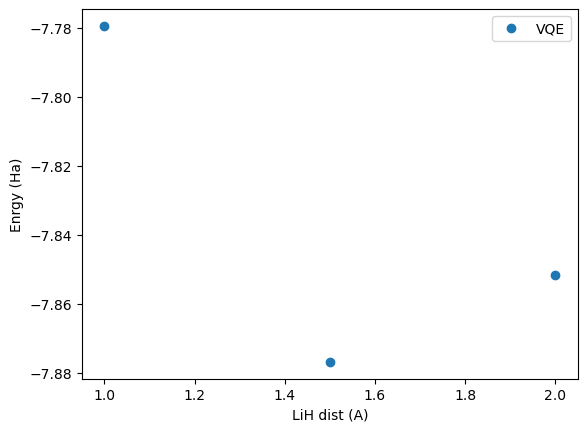

In [27]:
# plot results
dist = [1.0,1.5,2.0]

plt.plot(dist, final_energies, 'o', label = 'VQE')
plt.xlabel('LiH dist (A)')
plt.ylabel('Enrgy (Ha)')
plt.legend()
plt.show()